# Encoders mini-project:
## Implementation of a sentiment analysis model using an encoder

### I. Introduction

As seen in the explanation.ipnyb notebook, enven though encoders as implemented in this repository were introduced as part of a bigger architecture - the *transformer* architecture - they can be used as a standalone architecture for feature extraction in sequences. 

In this notebook, we will implement a simple sentiment analysis and make different tests and observation to illustrate what was said in the explanations. 

### II. Implementation of the model

First, let's import the code from model.py. The containt of this file if precisely what was done in the explanations notebook:

In [1]:
from model import SelfAttention, TransformerBlock, Encoder
import torch
import torch.nn as nn
import torch.functional as F

Now let's implement a sentiment analysis classifier model using the encoder:

In [2]:
class SentimentModel(nn.Module):
    def __init__(self,
                 src_vocab_size,
                 embed_size,
                 num_layers,
                 num_heads,
                 forward_expansion,
                 dropout,
                 max_length,
                 device,
                 num_classes):
        
        super(SentimentModel, self).__init__()
        self.num_classes = num_classes
        self.embed_size = embed_size

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            num_heads,
            device,
            forward_expansion,
            dropout,
            max_length
        )

        self.mean_pool = nn.AdaptiveAvgPool1d(1)  # Pooling to get a single vector for the sequence

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_size, num_classes),
        )

    def forward(self, x, mask):
        # x: (N, seq_length)
        encoded = self.encoder(x, mask)

        pooled = self.mean_pool(encoded.permute(0, 2, 1))  # (N, embed_size, 1)
        classified = self.classifier(pooled.squeeze(-1))  # (N, num_classes)
        return classified


### III. Configuration

In [ ]:
VOCAB_SIZE = 30522  # Taille vocab BERT
EMBED_SIZE = 256
NUM_LAYERS = 3
NUM_HEADS = 8
MAX_LENGTH = 128
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 5e-4
DROPOUT = 0.2
FORWARD_EXPANSION = 4

save_path = "best_checkpoint.pth"

### IV. Dataset importation

Now we'll use an usual dataset for sentiment analysis:

In [4]:
from tqdm import tqdm
from datasets import load_dataset

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
dataset = load_dataset("imdb")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Prepare the dataset:

In [6]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
import random

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
        # Tokenize et tronque à max_length
        return tokenizer(
            examples['text'], 
            truncation=True, 
            padding='max_length', 
            max_length=MAX_LENGTH,
            return_tensors="pt"
        )
    
# Apply tokenization
tokenized_train = dataset['train'].map(tokenize_function, batched=True)
tokenized_test = dataset['test'].map(tokenize_function, batched=True)

##################################################
## Comment to train on the whole dataset
def create_balanced_subset(dataset, size_per_class=500):
    """Créer un subset avec un nombre égal de chaque classe"""
    
    # Séparer par classe
    positive_indices = [i for i, sample in enumerate(dataset) if sample['label'] == 1]
    negative_indices = [i for i, sample in enumerate(dataset) if sample['label'] == 0]
    
    # Prendre size_per_class de chaque
    pos_subset = positive_indices[:size_per_class]
    neg_subset = negative_indices[:size_per_class]
    
    # Combiner et mélanger
    balanced_indices = pos_subset + neg_subset
    random.shuffle(balanced_indices)
    
    return dataset.select(balanced_indices)

tokenized_train = create_balanced_subset(tokenized_train, size_per_class=10000)
tokenized_test = create_balanced_subset(tokenized_test, size_per_class=1000) 

###########################################################################

tokenized_train.set_format(type='torch', columns=['input_ids', 'label'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'label'])

train_loader = DataLoader(
    tokenized_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

test_loader = DataLoader(
    tokenized_test, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

### V. Training

In [8]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"USING DEVICE: {device}")

model = SentimentModel(
        src_vocab_size=VOCAB_SIZE,
        embed_size=EMBED_SIZE,
        num_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        device=device,
        forward_expansion=FORWARD_EXPANSION,
        dropout=DROPOUT,
        max_length=MAX_LENGTH,
        num_classes=2  # Binaire: Positif/Négatif
    ).to(device)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

USING DEVICE: mps


Training loop:

In [9]:
train_losses, train_accuracies = [], []
val_accuracies = []
_best_accuracy = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n EPOCH {epoch+1}/{NUM_EPOCHS}")

    total_loss = 0
    all_predictions = []
    all_labels = []

    #########################
    ##### Train epoch: ######
    #########################
    model.train()
    for batch in tqdm(train_loader, desc="Training"):
        # Extract data from batch
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        
        # Reset the gradients of all optimized tensors
        optimizer.zero_grad()

        logits = model(input_ids, mask=None)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        # Metrics:
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print('Epoch loss', avg_loss, 'Epoch acc', accuracy)

    ##########################
    #### Evaluate epoch: #####
    ##########################

    model.eval()
    all_predictions = []
    all_labels = []
    total_loss = 0

    with torch.no_grad(): # Deactivate gradient computation
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, mask=None)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(test_loader)
        accuracy = accuracy_score(all_labels, all_predictions)
        report = classification_report(all_labels, all_predictions, 
                                     target_names=['Negative', 'Positive'])
        
        val_accuracies.append(accuracy)

        print("EVAL ACC:", accuracy)

        if accuracy > _best_accuracy:
            _best_accuracy = accuracy

            print(f"New best evaluation acc !")

            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
            }, save_path)


 EPOCH 1/15


Training: 100%|██████████| 625/625 [00:52<00:00, 11.97it/s]


Epoch loss 0.6270039718151093 Epoch acc 0.6367


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 35.12it/s]


EVAL ACC: 0.736
New best evaluation acc !

 EPOCH 2/15


Training: 100%|██████████| 625/625 [00:51<00:00, 12.06it/s]


Epoch loss 0.46826614599227906 Epoch acc 0.77845


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 36.11it/s]


EVAL ACC: 0.7715
New best evaluation acc !

 EPOCH 3/15


Training: 100%|██████████| 625/625 [00:51<00:00, 12.08it/s]


Epoch loss 0.39098210918903353 Epoch acc 0.825


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 36.03it/s]


EVAL ACC: 0.779
New best evaluation acc !

 EPOCH 4/15


Training: 100%|██████████| 625/625 [00:52<00:00, 11.85it/s]


Epoch loss 0.34404835259914396 Epoch acc 0.8512


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 28.74it/s]


EVAL ACC: 0.784
New best evaluation acc !

 EPOCH 5/15


Training: 100%|██████████| 625/625 [01:15<00:00,  8.28it/s]


Epoch loss 0.3087528144001961 Epoch acc 0.87115


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 26.28it/s]


EVAL ACC: 0.7885
New best evaluation acc !

 EPOCH 6/15


Training: 100%|██████████| 625/625 [01:02<00:00,  9.98it/s]


Epoch loss 0.2769698222875595 Epoch acc 0.8867


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 29.84it/s]


EVAL ACC: 0.7885

 EPOCH 7/15


Training: 100%|██████████| 625/625 [01:00<00:00, 10.38it/s]


Epoch loss 0.2504256855249405 Epoch acc 0.8975


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 28.78it/s]


EVAL ACC: 0.789
New best evaluation acc !

 EPOCH 8/15


Training: 100%|██████████| 625/625 [00:57<00:00, 10.82it/s]


Epoch loss 0.23365588150024413 Epoch acc 0.90595


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 30.76it/s]


EVAL ACC: 0.7965
New best evaluation acc !

 EPOCH 9/15


Training: 100%|██████████| 625/625 [00:59<00:00, 10.47it/s]


Epoch loss 0.2131418930053711 Epoch acc 0.91715


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 29.44it/s]


EVAL ACC: 0.798
New best evaluation acc !

 EPOCH 10/15


Training: 100%|██████████| 625/625 [01:00<00:00, 10.33it/s]


Epoch loss 0.19698530589938162 Epoch acc 0.9212


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 27.65it/s]


EVAL ACC: 0.78

 EPOCH 11/15


Training: 100%|██████████| 625/625 [01:03<00:00,  9.90it/s]


Epoch loss 0.18734349384605883 Epoch acc 0.926


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 27.32it/s]


EVAL ACC: 0.7915

 EPOCH 12/15


Training: 100%|██████████| 625/625 [01:01<00:00, 10.13it/s]


Epoch loss 0.1775642253190279 Epoch acc 0.92955


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 29.22it/s]


EVAL ACC: 0.793

 EPOCH 13/15


Training: 100%|██████████| 625/625 [01:02<00:00,  9.95it/s]


Epoch loss 0.16625545930564403 Epoch acc 0.9347


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 25.15it/s]


EVAL ACC: 0.786

 EPOCH 14/15


Training: 100%|██████████| 625/625 [01:00<00:00, 10.30it/s]


Epoch loss 0.16306191800683736 Epoch acc 0.9347


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 28.29it/s]


EVAL ACC: 0.7765

 EPOCH 15/15


Training: 100%|██████████| 625/625 [01:00<00:00, 10.33it/s]


Epoch loss 0.1666840919971466 Epoch acc 0.9342


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 29.18it/s]

EVAL ACC: 0.786


Random sampling to test results

In [10]:
import random

# Select ramdom samples
num_samples = 5
random_indices = random.sample(range(len(tokenized_test)), num_samples)

model.eval()
with torch.no_grad():
    for i, idx in enumerate(random_indices):
        sample = tokenized_test[idx]
        text = dataset['test'][idx]['text'] 
        true_label = sample['label'].item()

        input_ids = sample['input_ids'].unsqueeze(0).to(device) 

        logits = model(input_ids, mask=None)
        predicted_class = torch.argmax(logits, dim=1).item()
        confidence = torch.softmax(logits, dim=1).max().item()

        label_names = ['Negative', 'Positive']
        
        print(f"SAMPLE {i+1}:")
        print(f"Text: {text[:200]}..." if len(text) > 200 else f"Text: {text}")
        print(f"True Label: {label_names[true_label]}")
        print(f"Predicted: {label_names[predicted_class]}")
        print(f"Confidence: {confidence:.3f}")
        print(f"OOO Correct!" if predicted_class == true_label else "XXX Wrong!")



SAMPLE 1:
Text: In 4 words, Captain Corelli's Mandolin was "completely out of tune" with the book. The novel provided sufficient character background to understand the relationships and personal challenges the charac...
True Label: Negative
Predicted: Negative
Confidence: 0.993
OOO Correct!
SAMPLE 2:
Text: My husband brought this home from the video store, so I could watch something while stuck home sick. The sort of sick where you could never concentrate on a book, but a sorta silly, light, romantic fl...
True Label: Positive
Predicted: Negative
Confidence: 0.980
XXX Wrong!
SAMPLE 3:
Text: My wife and I watched this after DVR'ing it off of Encore action this past week. It has to be the worst horror flick either of us had ever seen. Predictable dialogue ( my wife and I were guessing the ...
True Label: Positive
Predicted: Negative
Confidence: 0.784
XXX Wrong!
SAMPLE 4:
Text: Watching Showtime I got the impression that the producers got the idea to put Robert DeNiro and Eddie Murphy jus

### VI. Visualisations

We can now make some tests to verify the theory explaned in the notebook.

1. Words with a similar meaning are wlose in the encoded representation space:

In [11]:
model.eval()

positive_words = ["masterpiece", "blockbuster", "hit", "success", "triumph", 
                 "great", "perfect", "brilliant", "amazing", "awesome", "fantastic", "incredible", "wonderful",
                 "excellent", "outstanding", "superb", "magnificent", "love", "adore", "enjoy", "appreciate", "treasure",
                 "happy", "joyful", "delighted", "thrilled", "excited"]
tokenized_positive_words = [tokenizer(word, return_tensors="pt", padding=True, truncation=True) for word in positive_words]

positive_embeddings = []
with torch.no_grad():
    for tokenized_positive_word in tokenized_positive_words:
        input_ids = tokenized_positive_word['input_ids'].to(device)

        encoded = model.encoder(input_ids, mask=None)  

        word_embedding = encoded.mean(dim=1).squeeze(0)

        positive_embeddings.append(word_embedding.cpu().numpy())

negative_words = ["pathetic", "terrible", "silly", "ridiculous", "terrible", "awful", "horrible", "disgusting", "hate", 
                 "bad", "worst", "disappointing", "boring", "annoying", "flop", "disaster", "failure", "bomb", "trash",
                "boring", "dull", "tedious", "slow", "dragging"]
tokenized_negative_words = [tokenizer(word, return_tensors="pt", padding=True, truncation=True) for word in negative_words]

negative_embeddings = []
with torch.no_grad():
    for tokenized_negative_word in tokenized_negative_words:
        input_ids = tokenized_negative_word['input_ids'].to(device)

        encoded = model.encoder(input_ids, mask=None)  

        word_embedding = encoded.mean(dim=1).squeeze(0)

        negative_embeddings.append(word_embedding.cpu().numpy())

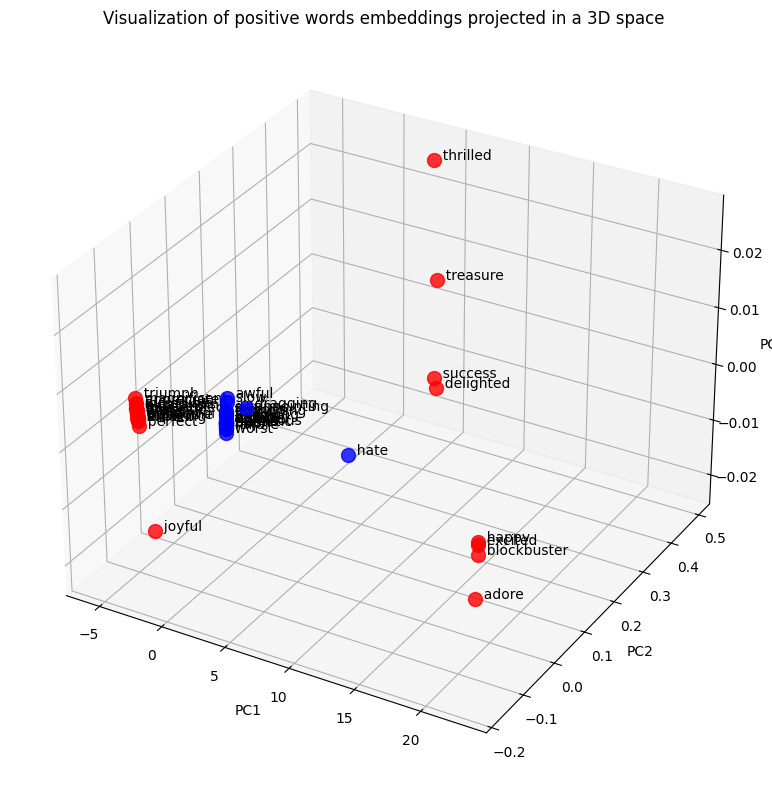

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
positive_embeddings_3d = pca.fit_transform(positive_embeddings)
negative_embeddings_3d = pca.fit_transform(negative_embeddings)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for word, embedding in zip(positive_words, positive_embeddings_3d):
    ax.scatter(embedding[0], embedding[1], embedding[2], 
                  c='red', s=100, alpha=0.8)
    ax.text(embedding[0], embedding[1], embedding[2], f'  {word}', fontsize=10)

for word, embedding in zip(negative_words, negative_embeddings_3d):
    ax.scatter(embedding[0], embedding[1], embedding[2], 
                  c='blue', s=100, alpha=0.8)
    ax.text(embedding[0], embedding[1], embedding[2], f'  {word}', fontsize=10)

ax.set_title('Visualization of positive words embeddings projected in a 3D space')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2') 
ax.set_zlabel('PC3')

plt.tight_layout()
plt.show()

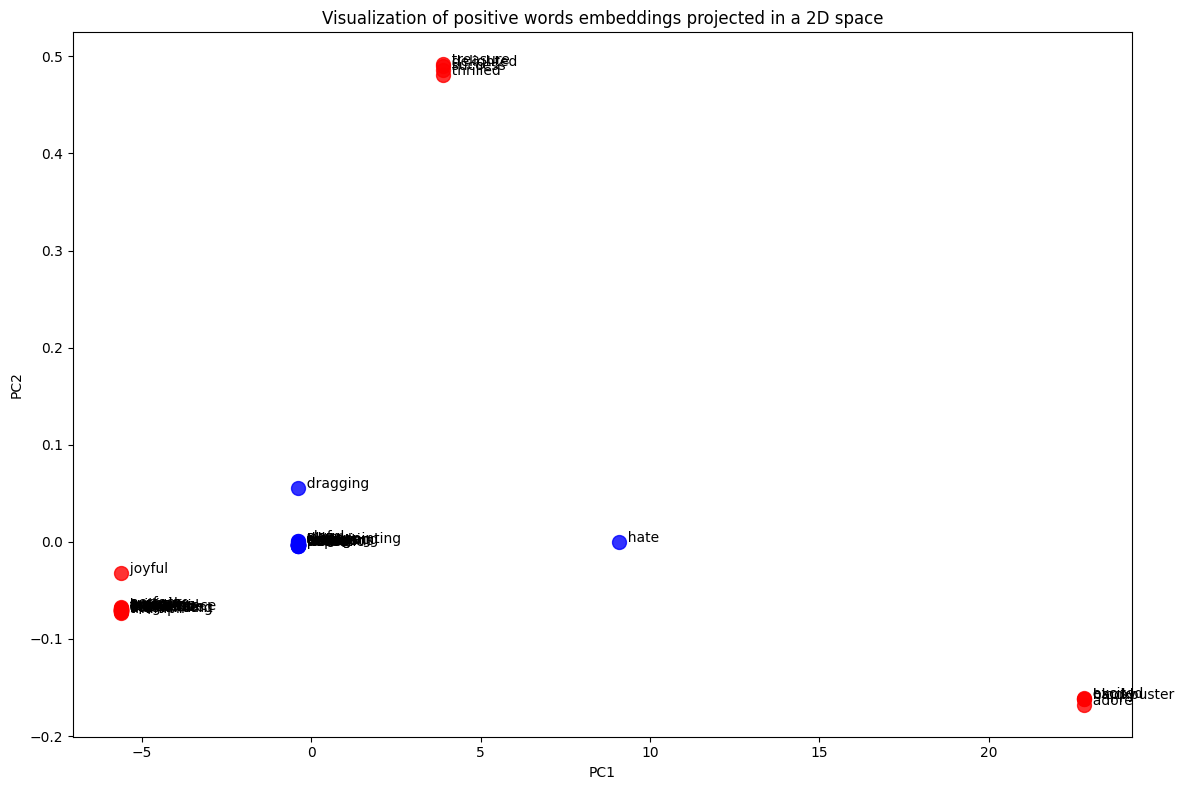

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
positive_embeddings_2d = pca.fit_transform(positive_embeddings)
negative_embeddings_2d = pca.fit_transform(negative_embeddings)

plt.figure(figsize=(12, 8))

for word, embedding in zip(positive_words, positive_embeddings_2d):
    plt.scatter(embedding[0], embedding[1], 
                  c='red', s=100, alpha=0.8)
    plt.text(embedding[0], embedding[1], f'  {word}', fontsize=10)

for word, embedding in zip(negative_words, negative_embeddings_2d):
    plt.scatter(embedding[0], embedding[1], 
                  c='blue', s=100, alpha=0.8)
    plt.text(embedding[0], embedding[1], f'  {word}', fontsize=10)

plt.title('Visualization of positive words embeddings projected in a 2D space')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

We can see, as expected from the theory, well separated embeddings between positive/negative words. 